# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [1]:
import json
import os
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Helper function to get paths relative to notebook location
def get_data_path(filename):
    """Get path to data file relative to this notebook's location"""
    # Get the current working directory and navigate to the data directory
    current_dir = os.getcwd()
    # Since notebooks are now in the root directory, data is in ./data/
    return os.path.join(current_dir, 'data', filename)

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [6]:
with open(get_data_path("imagenet_class_index.json")) as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

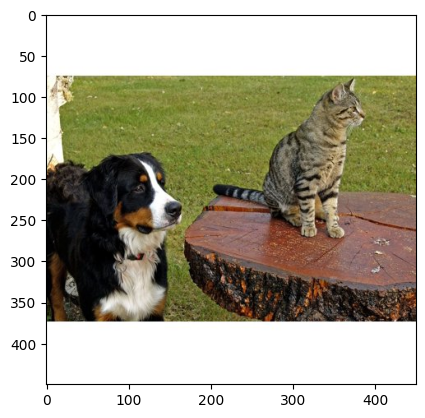

In [7]:
image_to_classify = get_image(get_data_path("dogs.png"))
plt.imshow(image_to_classify)

In [8]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [9]:
inception_v3 = models.inception_v3(pretrained=True)

/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Predykcja**

In [10]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [11]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [12]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935931
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [13]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

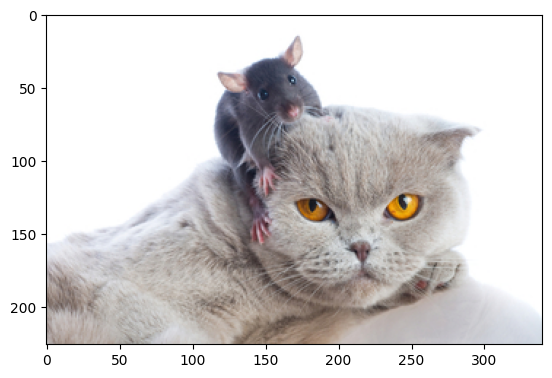

In [14]:
exercise_image = get_image(get_data_path("cat_mouse.jpeg"))
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [15]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [18]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

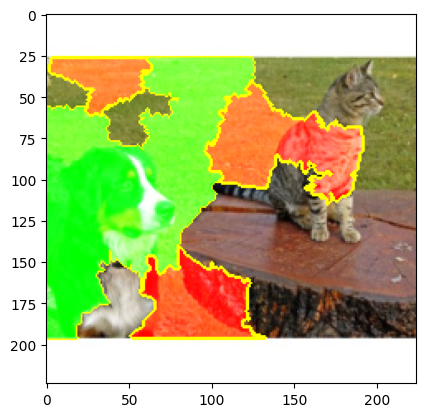

In [19]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

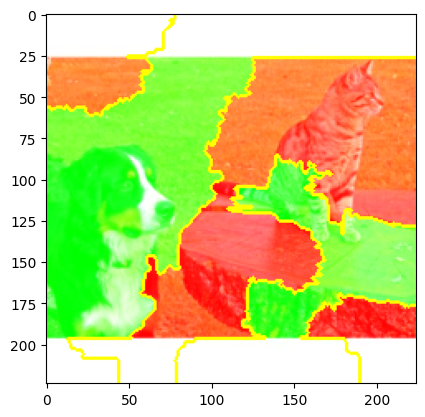

In [20]:
NUM_FEATURES = 50

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

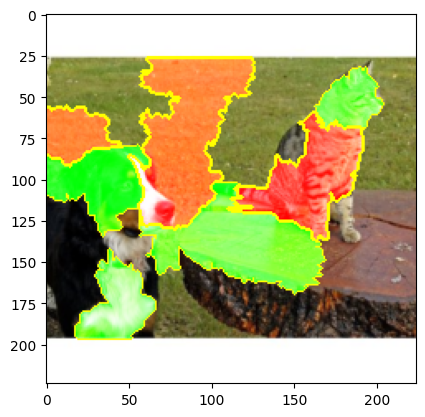

In [21]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

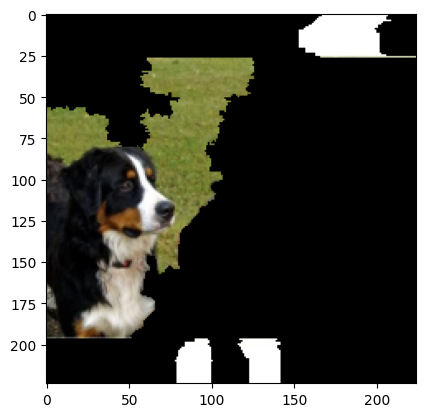

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

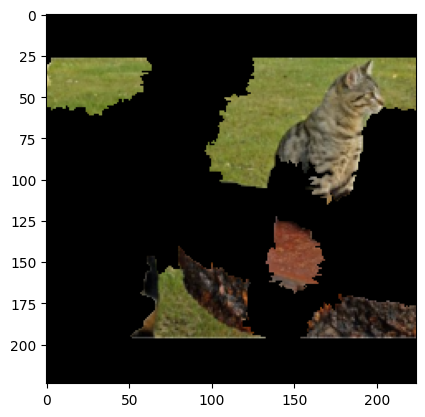

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [24]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: African_grey                   | Probability: 0.239753
Class: Egyptian_cat                   | Probability: 0.237234
Class: vulture                        | Probability: 0.091036
Class: tabby                          | Probability: 0.072441
Class: tiger_cat                      | Probability: 0.041429
Class: head_cabbage                   | Probability: 0.033961
Class: great_grey_owl                 | Probability: 0.023632
Class: ostrich                        | Probability: 0.019155
Class: lynx                           | Probability: 0.017204
Class: terrapin                       | Probability: 0.012652
Class: kite                           | Probability: 0.010088
Class: ice_bear                       | Probability: 0.010077
Class: komondor                       | Probability: 0.010044
Class: Madagascar_cat                 | Probability: 0.009317
Class: fountain                       | Probability: 0.007566


I jak go teraz widzi model

In [25]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

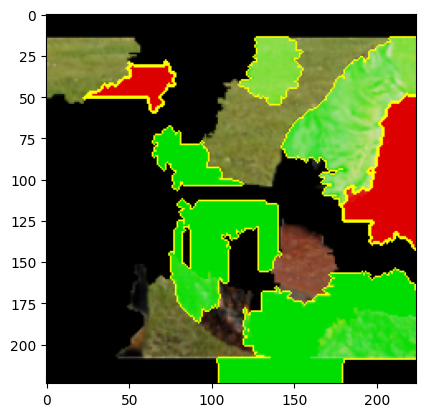

In [26]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [27]:
alexnet = models.alexnet(pretrained=True)

/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

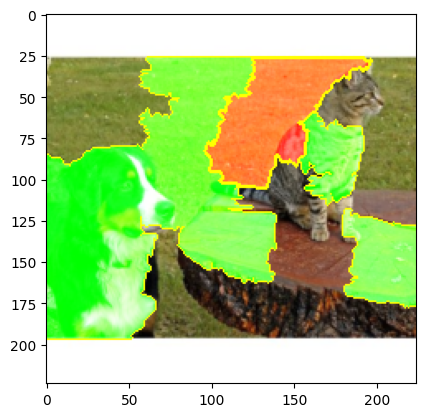

In [30]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [31]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935931
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:

![title](./data/amfibia.jpg)


In [32]:
amphibious_vehicle = get_image(get_data_path("amfibia.jpg"))

/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

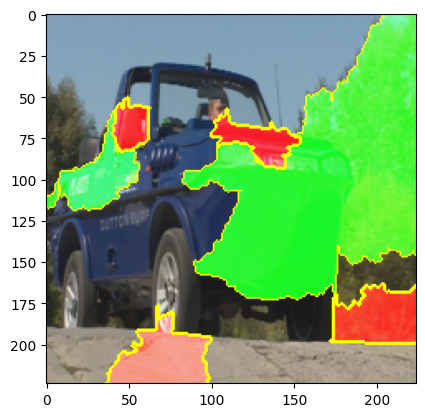

In [33]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [34]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie #1

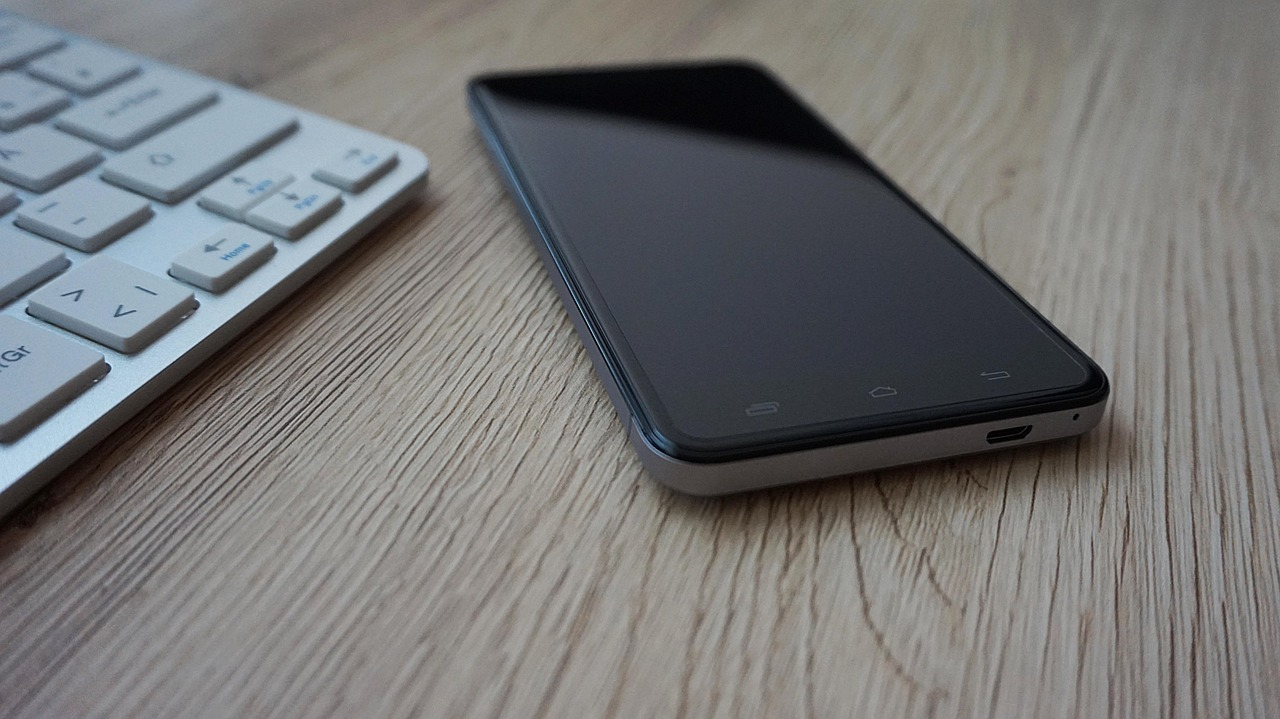

In [35]:
smartphone_image = get_image(get_data_path("smartphone.jpg"))
smartphone_image

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

In [36]:
resnet50 = models.resnet50(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/mateu/Education/sem9/ml/lab2/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1

In [37]:
explanation_resnet50 = explainer.explain_instance(
    image=lime_transformer(smartphone_image),
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000,
)

print("Top 5 classes for ResNet50:")
for index in explanation_resnet50.top_labels:
    print(f"- {index_to_label[index]}")

print("\nResNet50 prediction probabilities:")
get_prediction_probabilities(smartphone_image, resnet50)

  0%|          | 0/1000 [00:00<?, ?it/s]

Top 5 classes for ResNet50:
- cellular_telephone
- iPod
- notebook
- remote_control
- hand-held_computer

ResNet50 prediction probabilities:
Class: cellular_telephone             | Probability: 0.578285
Class: iPod                           | Probability: 0.207141
Class: notebook                       | Probability: 0.097887
Class: remote_control                 | Probability: 0.041161
Class: hand-held_computer             | Probability: 0.023550
Class: space_bar                      | Probability: 0.010947
Class: computer_keyboard              | Probability: 0.010938
Class: modem                          | Probability: 0.009541
Class: laptop                         | Probability: 0.009046
Class: mouse                          | Probability: 0.005640
Class: hard_disc                      | Probability: 0.002945
Class: typewriter_keyboard            | Probability: 0.000541
Class: radio                          | Probability: 0.000474
Class: desktop_computer               | Probability: 

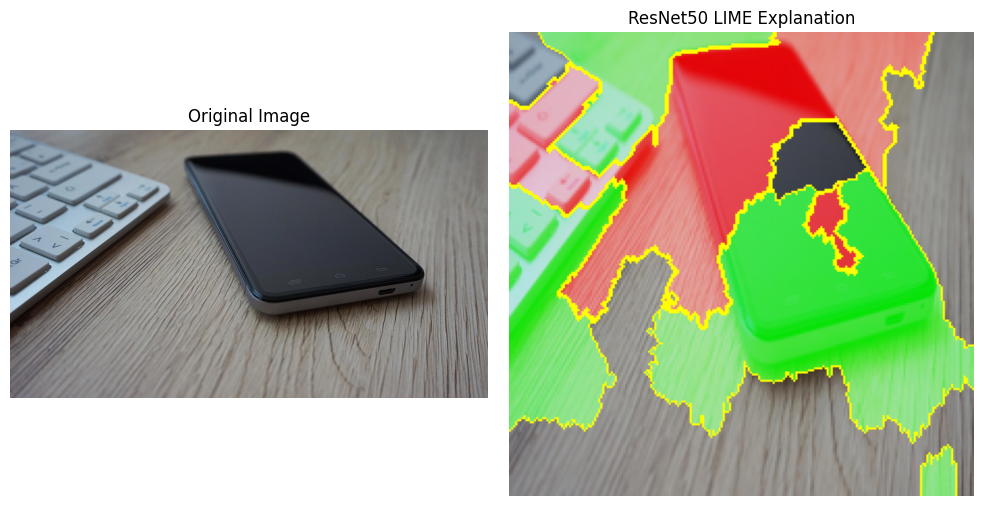

In [38]:
image_resnet50, mask_resnet50 = explanation_resnet50.get_image_and_mask(
    label=explanation_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=20,
    hide_rest=False)
boundaries_resnet50 = mark_boundaries(image_resnet50, mask_resnet50)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(smartphone_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(boundaries_resnet50)
plt.title("ResNet50 LIME Explanation")
plt.axis('off')
plt.tight_layout()

In [39]:
explanation_vgg16 = explainer.explain_instance(
    image=lime_transformer(smartphone_image),
    classifier_fn=partial(predict_batch, vgg16),
    top_labels=5,
    num_samples=1000,
)

print("Top 5 classes for VGG16:")
for index in explanation_vgg16.top_labels:
    print(f"- {index_to_label[index]}")

print("\nVGG16 prediction probabilities:")
get_prediction_probabilities(smartphone_image, vgg16)

  0%|          | 0/1000 [00:00<?, ?it/s]

Top 5 classes for VGG16:
- iPod
- cellular_telephone
- notebook
- space_bar
- modem

VGG16 prediction probabilities:
Class: iPod                           | Probability: 0.757578
Class: cellular_telephone             | Probability: 0.131088
Class: notebook                       | Probability: 0.057772
Class: space_bar                      | Probability: 0.011341
Class: modem                          | Probability: 0.008657
Class: laptop                         | Probability: 0.008191
Class: hand-held_computer             | Probability: 0.006694
Class: mouse                          | Probability: 0.004385
Class: computer_keyboard              | Probability: 0.004268
Class: remote_control                 | Probability: 0.004241
Class: hard_disc                      | Probability: 0.002348
Class: printer                        | Probability: 0.000821
Class: radio                          | Probability: 0.000624
Class: cassette_player                | Probability: 0.000216
Class: tape_pla

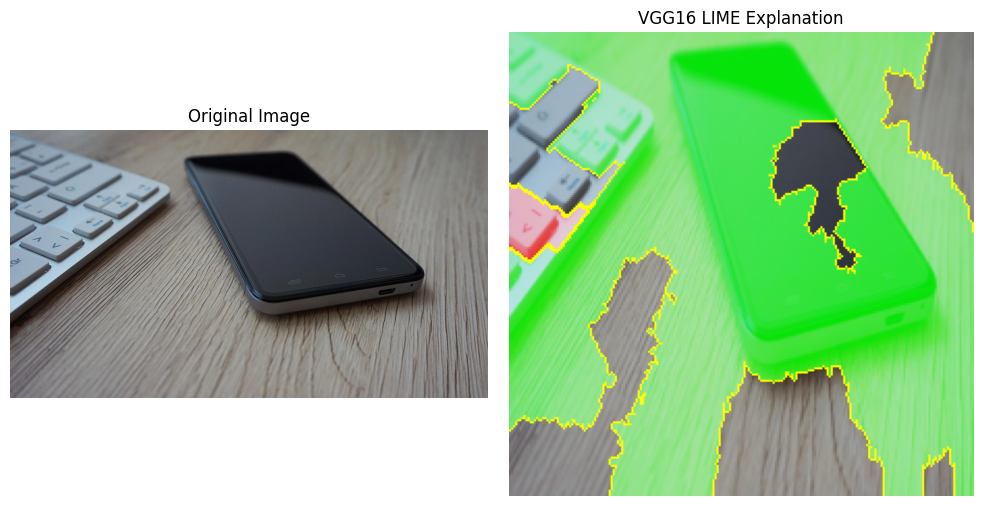

In [40]:
image_vgg16, mask_vgg16 = explanation_vgg16.get_image_and_mask(
    label=explanation_vgg16.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=20,
    hide_rest=False)
boundaries_vgg16 = mark_boundaries(image_vgg16, mask_vgg16)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(smartphone_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(boundaries_vgg16)
plt.title("VGG16 LIME Explanation")
plt.axis('off')
plt.tight_layout()

=== Model Comparison ===
ResNet50 top class: cellular_telephone
VGG16 top class: iPod


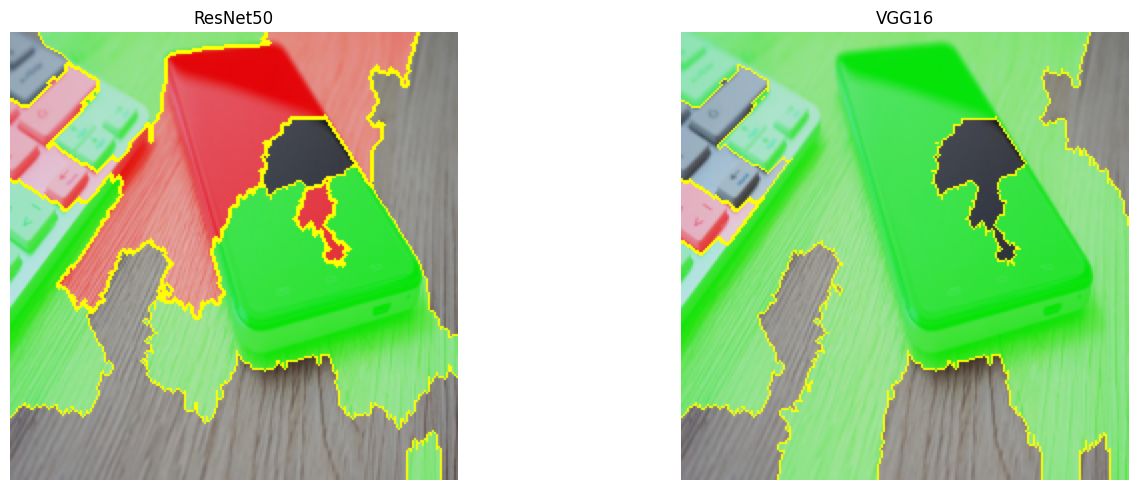

In [41]:
print("=== Model Comparison ===")
print("ResNet50 top class:", index_to_label[explanation_resnet50.top_labels[0]])
print("VGG16 top class:", index_to_label[explanation_vgg16.top_labels[0]])

# Create comparison visualization
plt.figure(figsize=(15, 5))

# Inception-v3
image_inc, mask_inc = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries_inc = mark_boundaries(image_inc, mask_inc)

plt.subplot(1, 2, 1)
plt.imshow(boundaries_resnet50)
plt.title("ResNet50")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(boundaries_vgg16)
plt.title("VGG16")
plt.axis('off')

plt.tight_layout()

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci była inna niż poprzednio klasa. W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

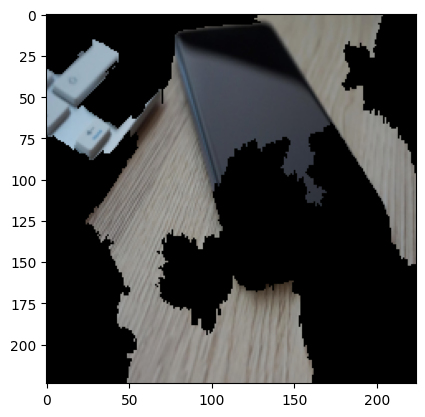

In [42]:
image_resnet50, mask_resnet50 = explanation_resnet50.get_image_and_mask(
    label=explanation_resnet50.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=20,
    hide_rest=True,
)
boundaries = mark_boundaries(image_resnet50, mask_resnet50)
cropped_image_ndarray = boundaries.astype(np.uint8)
plt.imshow(cropped_image_ndarray)

In [43]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, resnet50)

Class: pencil_sharpener               | Probability: 0.746120
Class: envelope                       | Probability: 0.071020
Class: paintbrush                     | Probability: 0.029006
Class: binder                         | Probability: 0.013991
Class: picket_fence                   | Probability: 0.012051
Class: paper_towel                    | Probability: 0.007422
Class: screw                          | Probability: 0.004898
Class: birdhouse                      | Probability: 0.004493
Class: broom                          | Probability: 0.003924
Class: iPod                           | Probability: 0.003298
Class: rule                           | Probability: 0.003158
Class: lampshade                      | Probability: 0.002941
Class: safety_pin                     | Probability: 0.002784
Class: hatchet                        | Probability: 0.002645
Class: window_shade                   | Probability: 0.002234


  0%|          | 0/1000 [00:00<?, ?it/s]

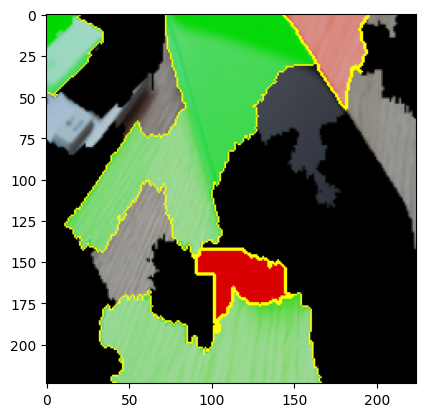

In [44]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000,
)

image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

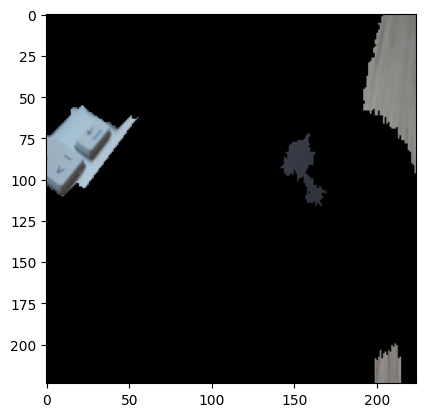

In [45]:
image_vgg16, mask_vgg16 = explanation_vgg16.get_image_and_mask(
    label=explanation_vgg16.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=20,
    hide_rest=True,
)
boundaries = mark_boundaries(image_vgg16, mask_vgg16)
cropped_image_ndarray = boundaries.astype(np.uint8)
plt.imshow(cropped_image_ndarray)

In [46]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, vgg16)

Class: space_shuttle                  | Probability: 0.218727
Class: syringe                        | Probability: 0.117182
Class: missile                        | Probability: 0.072164
Class: projectile                     | Probability: 0.032947
Class: airship                        | Probability: 0.029006
Class: obelisk                        | Probability: 0.010645
Class: wing                           | Probability: 0.010098
Class: picket_fence                   | Probability: 0.009419
Class: warplane                       | Probability: 0.009316
Class: spotlight                      | Probability: 0.008309
Class: daisy                          | Probability: 0.007363
Class: radio_telescope                | Probability: 0.006717
Class: quill                          | Probability: 0.006221
Class: bell_cote                      | Probability: 0.005890
Class: analog_clock                   | Probability: 0.005721


  0%|          | 0/1000 [00:00<?, ?it/s]

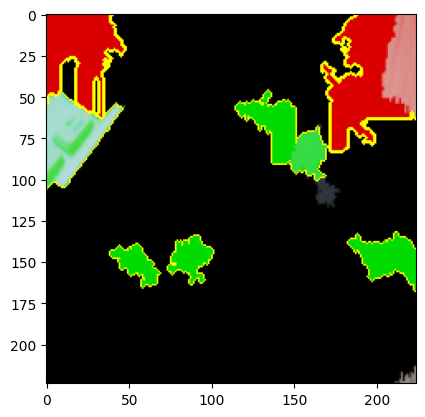

In [47]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, vgg16),
    top_labels=5,
    num_samples=1000,
)

image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)